In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Read the data

In [ ]:
df = pd.read_csv("drive/My Drive/datasets/imdb.csv")

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.sentiment.replace(["positive","negative"],[1,0], inplace=True)

In [ ]:
df.review = df.review.str.lower()
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. <br /><br />the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


In [ ]:
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub('<.*?>'," ", txt)         #Remove html tags  
    txt = re.sub("[^a-z]", " ", txt)  #Remove special characters 
    txt =  txt.split()
    txt = [w for w in txt if not w in set(stopwords.words("english")) ]
    
    return txt
# len(clean_text(txt))

In [ ]:
data_X = df.review.to_list()[:25000]
data_Y = df.sentiment.to_list()[:25000]

In [ ]:
for i in range(len(data_X)):
    data_X[i] = clean_text(data_X[i])
    if (i+1) % 5000 == 0:
      print(i+1)

5000
10000
15000


In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=0.2)

In [ ]:
words_list = []
for sent in train_X:
    for word in sent:
        words_list.append(word)

In [ ]:
counter_words = Counter(words_list)

In [ ]:
with open("/content/drive/My Drive/models/SA_LSTM/data_X.bin", "wb") as f:
    pickle.dump(data_X,f)
with open("/content/drive/My Drive/models/SA_LSTM/data_Y.bin","wb") as f:
    pickle.dump(data_Y,f)

In [ ]:
vocab = torchtext.vocab.Vocab(counter_words,max_size=15000).stoi

In [ ]:
len(vocab)

15001

In [ ]:
with open("/content/drive/My Drive/models/SA_LSTM/vocab.bin", "wb") as f:
    pickle.dump(vocab,f)

In [ ]:
for i in range(len(train_X)):
    for j in range(len(train_X[i])):
        word = train_X[i][j]
        train_X[i][j] = vocab[word]

In [ ]:
for i in range(len(test_X)):
    for j in range(len(test_X[i])):
        word = test_X[i][j]
        test_X[i][j] = vocab[word]

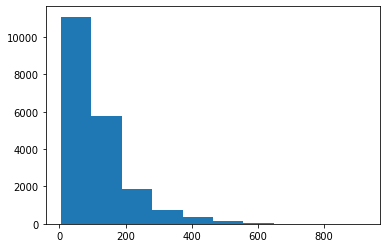

In [ ]:
sent_lengths = [len(i) for i in train_X]
plt.hist(sent_lengths)
plt.show()

In [ ]:
# def pad_trunc(arr, max_len):
#     for i in range(len(arr)):
#         temp = []
#         for j in range(max_len):
#             if j < len(arr[i]):
#                 temp.append(arr[i][j])
#             else:
#                 temp.append(0)
#         arr[i] = temp
#     return arr
def to_list_of_tensor(arr):
    ret_arr = []
    for tens in arr:
        tens = [tens]
        ret_arr.append(torch.tensor(tens))
    return ret_arr

In [ ]:
train_X = to_list_of_tensor(train_X)
train_Y = torch.tensor(train_Y)
test_X = to_list_of_tensor(test_X)
test_Y = torch.tensor(test_Y)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu") 

## LSTM Model

In [ ]:
class LSTM_Model(nn.Module):
    def __init__(self, hidden_size, embedding_dim,vocab_size):
        super(LSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, 2)
        self.predictor = nn.Linear(hidden_size,1)
        
    def forward(self,data):
        
        emb_out = self.embedding(data)
        output, _ = self.lstm(emb_out)
        pred = self.predictor(output[:,-1,:])    ## Use the output from the last LSTM Cell
        label = torch.sigmoid(pred)
        
        return label


In [ ]:
def train(model, optimizer, criterion, epochs, batch_size, train_X, train_Y, test_X, test_Y):
    for e in range(epochs):
        train_loss = 0
        train_acc = 0

        test_loss = 0
        test_acc = 0
        # model.train()
        for i in range(len(train_X)):
            x = train_X[i].to(device)
            y = train_Y[i:i+1].to(device)
            y = y.float()
            optimizer.zero_grad()
            prediction = model(x)
            prediction = prediction.squeeze(1)
            loss = criterion(prediction,y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.data.item()
            train_acc += torch.eq(prediction.round(),y).sum().item()
        train_loss /= len(train_X)
        train_acc /= len(train_X)
        

        for i in range(len(test_X)):
            x = test_X[i].to(device)
            y = test_Y[i:i+1].to(device)
            y = y.float()
            prediction = model(x)
            prediction = prediction.squeeze(1)
            loss = criterion(prediction,y)

            test_loss += loss.data.item()
            test_acc += torch.eq(prediction.round(),y).sum().item()
        test_loss /= len(test_X)
        test_acc /= len(test_X)

        if (e+1)%10 == 0:
            torch.save(model, "/content/drive/My Drive/models/SA_LSTM/model/e_" + str(e+1)+".bin")
        print("Epoch: {}  Training (loss,acc): ({},{})  Test (loss, acc):({},{})".format( e+1, train_loss, train_acc, test_loss, test_acc))


In [ ]:
vocab_size = len(vocab)
model = LSTM_Model(100,300, vocab_size)

model.to(device)

optimizer = torch.optim.SGD(model.parameters(), 0.01)
criterion = nn.BCELoss()

train(model, optimizer, criterion, 100, 50, train_X, train_Y, test_X, test_Y)

Epoch: 1  Training (loss,acc): (0.6923666529089212,0.5138)  Test (loss, acc):(0.688944425702095,0.5284)
Epoch: 2  Training (loss,acc): (0.6765942613214254,0.5732)  Test (loss, acc):(0.666229634848237,0.5786)
Epoch: 3  Training (loss,acc): (0.6517864498473704,0.60095)  Test (loss, acc):(0.6587404029741883,0.5918)
Epoch: 4  Training (loss,acc): (0.6313175556384027,0.62805)  Test (loss, acc):(0.6582677534908056,0.6012)
Epoch: 5  Training (loss,acc): (0.6144685355097056,0.64785)  Test (loss, acc):(0.662145113433525,0.605)
Epoch: 6  Training (loss,acc): (0.6006504660399631,0.6607)  Test (loss, acc):(0.6683942809797824,0.604)
Epoch: 7  Training (loss,acc): (0.589276663387008,0.6718)  Test (loss, acc):(0.6752902288271114,0.6058)
Epoch: 8  Training (loss,acc): (0.5798940419183113,0.6777)  Test (loss, acc):(0.6819024157332256,0.604)
Epoch: 9  Training (loss,acc): (0.5721677602029173,0.67885)  Test (loss, acc):(0.6876582521336153,0.6054)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LSTM_Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 10  Training (loss,acc): (0.5657990441309987,0.67925)  Test (loss, acc):(0.692720527705364,0.6054)
Epoch: 11  Training (loss,acc): (0.560429824092635,0.6803)  Test (loss, acc):(0.6973718810885213,0.605)
Epoch: 12  Training (loss,acc): (0.5558590610648971,0.67945)  Test (loss, acc):(0.7018130290534347,0.6064)
Epoch: 13  Training (loss,acc): (0.5519337650789181,0.6803)  Test (loss, acc):(0.7059431125198491,0.606)
Epoch: 14  Training (loss,acc): (0.5484887847736128,0.68065)  Test (loss, acc):(0.7100276134869083,0.6064)
Epoch: 15  Training (loss,acc): (0.5453822255688021,0.68095)  Test (loss, acc):(0.7140563306361437,0.6068)
Epoch: 16  Training (loss,acc): (0.5425780954002868,0.68115)  Test (loss, acc):(0.7179260853809305,0.606)
Epoch: 17  Training (loss,acc): (0.5400383495013346,0.68195)  Test (loss, acc):(0.721596492450824,0.606)
Epoch: 18  Training (loss,acc): (0.5376965411976679,0.68135)  Test (loss, acc):(0.725125832038885,0.6064)
Epoch: 19  Training (loss,acc): (0.535519123071

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

5504001